## <font color='green'>Churn prediction for Telecom</font>

github link: https://github.com/aditya-karampudi/churn_prediction

### <font color='blue'>Main tasks</font>
1. Exploratory data analysis using visualizations in Jupyter notebook.
2. Built a model that predicts whether a customer churns or not from the company.

### Problem Description
To predict the telecom customers who are likely to exit the contract and also to generate patterns of Churn and non-churn to assist the management to take appropriate decisions to limit churn.

### Data
The datasets are provided as cited below for the analysis:

**Demographics Data:** “Train_Demographics.csv” & “Test_Demographics.csv” These files consist of the demographic data of each customer, like HouseholdID, Country, State, Education, Gender etc.

**Account Information:** “Train_AccountInfo.csv” & “Test_AccountInfo.csv” These files consist of the customer account information with the telecom company, like CustomerID, DOE, Contract Type, Paymentmethod etc.

**Data of ServicesOptedFor:** “Train_ServicesOptedFor.csv” & “Test_ServicesOptedFor.csv” These files consist of the details about the services the customers signed for.

**Churn Data:** “Train.csv” & “Test.csv” This “Train.csv” table contains the Customer churn details - CustomerID, Churn. This “Test.csv” contains only CustomerID (Not target attribute, which is to be predicted) 5. Attributes Details: “AttributeInformation.docx” This has the details of attributes for the datasets cited above (1 to 4)

## Approach:
    1. Data Import
    2. Data Wrangling
    3. Feature Generation
    4. Visualization
    5. Missing value imputation
    6. Model and Evaluation 

In [1]:
#Importing necessary libraries
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.get_backend()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the data and saving it in different libraries
train = pd.read_csv("data/Train.csv")
Train_AccountInfo = pd.read_csv("data/Train_AccountInfo.csv")
Train_Demographics = pd.read_csv("data/Train_Demographics.csv")
Train_ServicesOptedFor = pd.read_csv("data/Train_ServicesOptedFor.csv")
print(train.shape)
train.head()

(5298, 2)


,CustomerID,Churn
0,Cust4327,Yes
1,Cust3826,No
2,Cust6200,No
3,Cust1467,No
4,Cust4843,No


### Plot of distribution of Y - churn or no churn

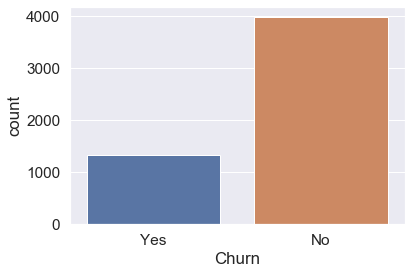

In [124]:
sns.countplot(x="Churn", data=train)
#the data is highly imbalanced..

In [125]:
#looking at the data of another file
print(Train_AccountInfo.shape)
Train_AccountInfo.head(2)

(5298, 8)


,CustomerID,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod
0,Cust1450,417.75,5-1-2012,3400.25,10-May-11,Yes,Month-to-month,Electronic check
1,Cust4452,500.00,5-1-2012,7673.75,12-Sep-10,Yes,Month-to-month,Electronic check


### <font color='green'>Merging different dataframes based on the ID of customer</font>

In [126]:
#Merging two dataframes with customerid attribute
train_train_account= pd.merge(Train_AccountInfo,train,on="CustomerID")
train_train_account[train_train_account.CustomerID == "Cust1450"] #checking the merged dataframe
#renaming a column to match
Train_Demographics = Train_Demographics.rename(columns={ "HouseholdID" : "CustomerID"})
#Train_Demographics['HouseholdID'] = "CustomerID"
train_account_demo = pd.merge(Train_Demographics,train_train_account, on="CustomerID")
train_account_demo.head(1)

,CustomerID,Country,State,Retired,HasPartner,HasDependents,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust5390,India,Maharashtra,0,2,2,Graduation,Female,106.0,5-1-2012,1113.25,11-Mar-11,Yes,Month-to-month,Electronic check,No


In [127]:
#This is the distribution of the services opted by all of the users.
Train_ServicesOptedFor.SeviceDetails.value_counts()

No                     17410
Yes                    13390
No internet service     6936
1                       4792
Fiber optic             2313
DSL                     1829
No phone service         506
0                        506
Name: SeviceDetails, dtype: int64

_**The services opted by different users is different lets replace the values where the customer did not subscribe with NO
and replace values where the customer subscribed with YES**_

In [128]:
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "1"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "No internet service"] = "No"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "0"] = "No"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "Fiber optic"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "DSL"] = "Yes"
Train_ServicesOptedFor.SeviceDetails[Train_ServicesOptedFor.SeviceDetails == "No phone service"] = "No"

##### By removing the records that have NO, we will have the services that each customer has chosen. Now lets dummify those services 

In [129]:
yes_train_service = Train_ServicesOptedFor[Train_ServicesOptedFor.SeviceDetails != 'No']
yes_train_service = yes_train_service.sort_values(by=['TypeOfService'], ascending=['True'])
ff = pd.get_dummies(yes_train_service, prefix=['TypeOfService'],
               columns=['TypeOfService'])

##### we have multiple records with same customer id as a customer might be subscribed to many services. Hence adding the multiple rows to single rows

In [130]:
#viewing at the service opted by a single customer
Train_ServicesOptedFor[Train_ServicesOptedFor.CustomerID == "Cust1255"]

,CustomerID,TypeOfService,SeviceDetails
11101,Cust1255,OnlineSecurity,No
12988,Cust1255,StreamingMovies,Yes
27062,Cust1255,InternetServiceCategory,Yes
31521,Cust1255,StreamingTelevision,Yes
32944,Cust1255,TechnicalSupport,No
39891,Cust1255,OnlineBackup,No
43740,Cust1255,HasPhoneService,Yes
45015,Cust1255,MultipleLines,No
45697,Cust1255,DeviceProtection,No


In [131]:
pp = ff.groupby('CustomerID')['SeviceDetails'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
pp.columns = pp.columns.droplevel()
pp.columns = ['CustomerID','TypeOfService_DeviceProtection', 'TypeOfService_HasPhoneService', 
              'TypeOfService_InternetServiceCategory','TypeOfService_StreamingMovies','TypeOfService_StreamingTelevision',
              'TypeOfService_OnlineBackup','TypeOfService_OnlineSecurity',
             'TypeOfService_MultipleLines',
              'TypeOfService_TechnicalSupport']
pp = pp.replace({'Yes': 1, None: 0})
train_account_demo = pd.merge(pp,train_account_demo, on="CustomerID",how='inner')
train_account_demo.head(1) #we have dummified dataset with 1 in the service customer subscribed

,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
0,Cust1201,1,1,1,1,1,0,0,0,0,...,Masters,Male,478.5,5-1-2012,5920,10-Jan-11,No,One year,Electronic check,No


## Visualization

### <font color='green'> **__The below plot revelas that the highest education level of the customers is High school__**</font>

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

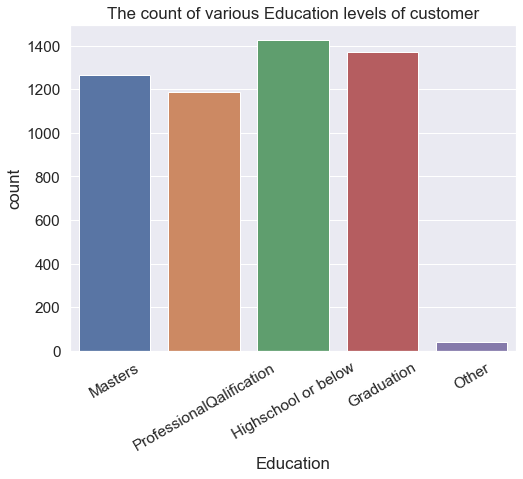

In [132]:
#distribution of education
fig, ax = plt.subplots(figsize=(8,6)) 
sns.countplot(x="Education", data=train_account_demo)
plt.title("The count of various Education levels of customer")
plt.xticks(rotation=30)

### <font color='green'> **__Also the most selling category of subscription is Monthly contract__**</font>

Text(0.5, 1.0, 'The type of Contract')

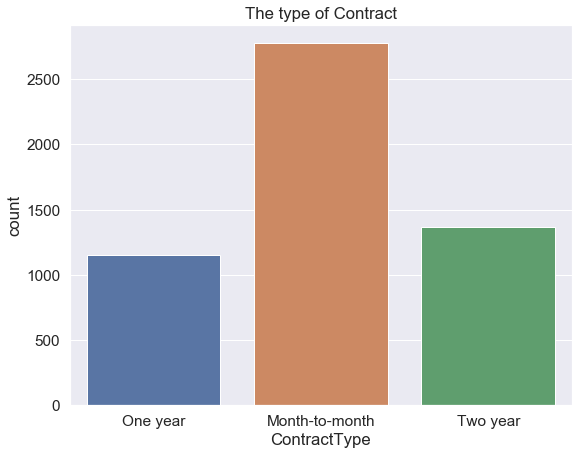

In [133]:
fig, ax = plt.subplots(figsize=(9,7)) 
sns.countplot(x="ContractType", data=train_account_demo)
plt.title("The type of Contract")

### <font color='green'> The churn analysis of different education level shows that the Masters level people has the least churn rate </font>

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

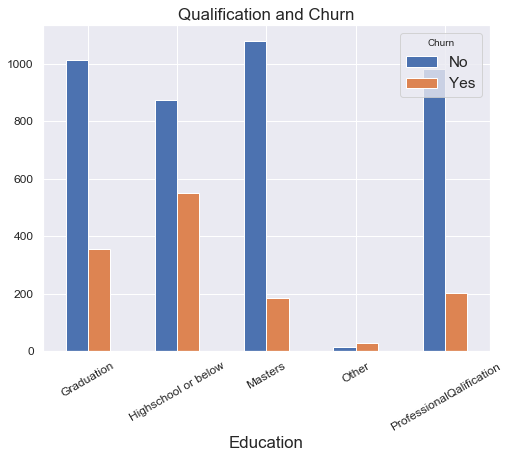

In [134]:
train_account_demo_group = train_account_demo.groupby(['Education','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(8,6),
                                   title='Qualification and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')
plt.xticks(rotation=30)

### <font color='green'> This is an interesting plot. The churn rate is more with retired customers</font>

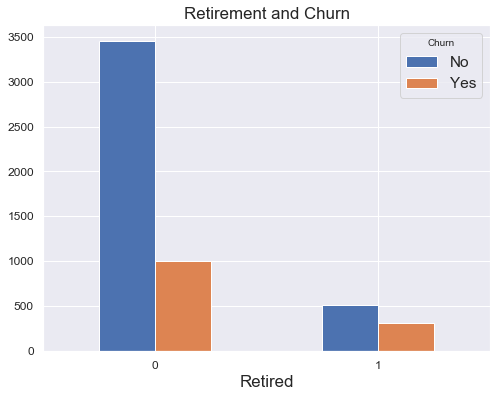

In [135]:
train_account_demo_group = train_account_demo.groupby(['Retired','Churn']).size()
train_account_demo_group_stack = train_account_demo_group.unstack(1).fillna('0')
train_account_demo_group_stack.plot(kind='bar',label='Education',figsize=(8,6),
                                   title='Retirement and Churn',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

### <font color='green'> Formatting data for training Machine learning models</font>

In [136]:
#lets do downsampling as the data is highly imbalanced
yes_train = train_account_demo[train_account_demo.Churn == "Yes"]
yes_train.reset_index(inplace=True,drop=True)
no_train = train_account_demo[train_account_demo.Churn == "No"]
no_train.reset_index(inplace=True,drop=True)
print(yes_train.shape)
print(no_train.shape)
no_train_1324 = no_train.sample(1324)
train_final = yes_train.append(no_train_1324)
print((train_final.shape))

(1324, 25)
(3974, 25)
(2648, 25)


## Missing Value Imputation

In [137]:
#Number of missng values in each clumn
train_final.isnull().sum()

CustomerID                               0
TypeOfService_DeviceProtection           0
TypeOfService_HasPhoneService            0
TypeOfService_InternetServiceCategory    0
TypeOfService_StreamingMovies            0
TypeOfService_StreamingTelevision        0
TypeOfService_OnlineBackup               0
TypeOfService_OnlineSecurity             0
TypeOfService_MultipleLines              0
TypeOfService_TechnicalSupport           0
Country                                  0
State                                    0
Retired                                  0
HasPartner                               0
HasDependents                            0
Education                                5
Gender                                   2
BaseCharges                              0
DOC                                      0
TotalCharges                             3
DOE                                      0
ElectronicBilling                        0
ContractType                             3
PaymentMeth

In [138]:
#now lets do missing value analysis
train_final[train_final.Country == "?"]
#there are only two records which have country as ?
#it is evident from state that the country is INDIA
train_final.Country[train_final.Country == "?"] = "India"

In [139]:
#having look at state values
print(train_final.State.value_counts())
train_final[train_final.State == "?"]

Maharashtra    2645
?                 3
Name: State, dtype: int64


,CustomerID,TypeOfService_DeviceProtection,TypeOfService_HasPhoneService,TypeOfService_InternetServiceCategory,TypeOfService_StreamingMovies,TypeOfService_StreamingTelevision,TypeOfService_OnlineBackup,TypeOfService_OnlineSecurity,TypeOfService_MultipleLines,TypeOfService_TechnicalSupport,...,Education,Gender,BaseCharges,DOC,TotalCharges,DOE,ElectronicBilling,ContractType,PaymentMethod,Churn
664,Cust3825,1,1,1,1,1,1,0,0,0,...,Graduation,Female,501.25,5-1-2012,11938.75,16-Dec-09,Yes,Month-to-month,Electronic check,Yes
1268,Cust6152,1,1,1,1,0,0,0,0,0,...,Masters,Female,276.00,5-1-2012,2641.75,11-Mar-11,No,Month-to-month,Credit card (automatic),Yes
1125,Cust2696,1,1,1,1,1,0,0,0,0,...,ProfessionalQalification,Male,477.50,5-1-2012,908.25,6-Nov-11,Yes,Month-to-month,Credit card (automatic),No


In [140]:
#we can replace ? with maharastra as the whole data consists only maharashtra
train_final.State[train_final.State == "?"] = "Maharashtra"

In [141]:
#as the NA values are less for other columns
#replacing NA with mode for every column
for column in train_final.columns:
    train_final[column].fillna(train_final[column].mode()[0], inplace=True)

In [142]:
#replacing the MISSINGVAL in totalcharges column with the minimum value of the column i.e 100
#print(train_final.TotalCharges.min())
train_final.TotalCharges[train_final.TotalCharges == "MISSINGVAL"] =100
#train_final['TotalCharges'] = train_final['TotalCharges'].map({'MISSINGVAL': 100})

# Data Pre-processing

In [143]:
#changing the dates to proper format at then creating a new attribute which will give the tenure of the customer
train_final['DOC'] = pd.to_datetime(train_final['DOC'], format='%d-%m-%Y')

train_final['DOE']=train_final.DOE.apply(
    lambda x: pd.to_datetime(x).strftime('%d-%b-%Y'))

train_final['DOE']=pd.to_datetime(train_final['DOE'], format='%d-%b-%Y')

train_final['tenure'] = (train_final['DOC']-train_final['DOE']).dt.days

In [144]:
#Now lets convert the dataframe columns into the respective format
categoricalFeatureNames = ["Country","State","Retired","HasPartner","HasDependents","Education", "Gender","ElectronicBilling",
                          "ContractType","PaymentMethod"]

numericalFeatureNames = ["TotalCharges","BaseCharges","tenure"]
#these are the numerical attributes

#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    train_final[var] = train_final[var].astype("category")
    
#convert the attributes listed above to categorical form
for nar in numericalFeatureNames:
    train_final[nar] = train_final[nar].astype("float64")

In [145]:
train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
y = train_final[['Churn']]

train_final = pd.get_dummies(train_final, prefix=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'],
               columns=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'])

data_final = train_final.drop(['CustomerID','Country','State','DOC','DOE','Churn'], axis=1)

## Test Data

In [146]:
train = pd.read_csv("data/Test.csv")
Test_AccountInfo = pd.read_csv("data/Test_AccountInfo.csv")
Test_Demographics = pd.read_csv("data/Test_Demographics.csv")
Test_ServicesOptedFor = pd.read_csv("data/Test_ServicesOptedFor.csv")
#merging two dataframes with customerid attribute
test_test_account= pd.merge(Test_AccountInfo,train,on="CustomerID")
#renaming a column to match
Test_Demographics = Test_Demographics.rename(columns={ "HouseholdID" : "CustomerID"})
#Train_Demographics['HouseholdID'] = "CustomerID"
test_account_demo = pd.merge(Test_Demographics,test_test_account, on="CustomerID")
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "1"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "No internet service"] = "No"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "0"] = "No"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "Fiber optic"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "DSL"] = "Yes"
Test_ServicesOptedFor.SeviceDetails[Test_ServicesOptedFor.SeviceDetails == "No phone service"] = "No"
yes_test_service = Test_ServicesOptedFor[Test_ServicesOptedFor.SeviceDetails != 'No']
yes_test_service = yes_test_service.sort_values(by=['TypeOfService'], ascending=['True'])
fff = pd.get_dummies(yes_test_service, prefix=['TypeOfService'],
               columns=['TypeOfService'])
xxx = fff.groupby('CustomerID')['SeviceDetails'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
xxx.columns = xxx.columns.droplevel()
xxx.columns = ['CustomerID','TypeOfService_DeviceProtection', 'TypeOfService_HasPhoneService', 
              'TypeOfService_InternetServiceCategory','TypeOfService_StreamingMovies','TypeOfService_StreamingTelevision',
              'TypeOfService_OnlineBackup','TypeOfService_OnlineSecurity',
             'TypeOfService_MultipleLines',
              'TypeOfService_TechnicalSupport']
xxx = xxx.replace({'Yes': 1, None: 0})
test_account_demo = pd.merge(xxx,test_account_demo, on="CustomerID",how='inner')
# test_account_demo.head(2)
#as the NA values are less 
#replacing NA with mode for every column
for column in test_account_demo.columns:
    test_account_demo[column].fillna(test_account_demo[column].mode()[0], inplace=True)
test_account_demo.Country[test_account_demo.Country == "?"] = "India"
test_account_demo.TotalCharges[test_account_demo.TotalCharges == "MISSINGVAL"] = 100
#changing the dates to proper format at then creating a new attribute which will give the tenure of the customer
test_account_demo['DOC'] = pd.to_datetime(test_account_demo['DOC'], format='%d-%m-%Y')

test_account_demo['DOE']=test_account_demo.DOE.apply(
    lambda x: pd.to_datetime(x).strftime('%d-%b-%Y'))

test_account_demo['DOE']=pd.to_datetime(test_account_demo['DOE'], format='%d-%b-%Y')

test_account_demo['tenure'] = (test_account_demo['DOC']-test_account_demo['DOE']).dt.days
#Now lets convert the dataframe columns into the respective format

categoricalFeatureNames = ["Country","State","Retired","HasPartner","HasDependents","Education", "Gender","ElectronicBilling",
                          "ContractType","PaymentMethod"]

#"Retired","HasPartner","HasDependents","Education","Gender","BaseCharges","TotalCharges",
#                         "ElectronicBilling","ContractType"


numericalFeatureNames = ["TotalCharges","BaseCharges","tenure"]
#these are the numerical attributes

#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    test_account_demo[var] = test_account_demo[var].astype("category")
    
#convert the attributes listed above to categorical form
for nar in numericalFeatureNames:
    test_account_demo[nar] = test_account_demo[nar].astype("float64")

test_account_demo = pd.get_dummies(test_account_demo, prefix=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'],
               columns=['Retired','HasPartner','HasDependents','Education','Gender','ElectronicBilling','ContractType','PaymentMethod'])

test_final = test_account_demo.drop(['CustomerID','Country','State','DOC','DOE'], axis=1)
test_final['PaymentMethod_Credit card (automatic)'] = 0

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_final, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1986, 34)
(662, 34)
(1986, 1)
(662, 1)


## Logistic Regression

In [154]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
seed=12
logreg = LogisticRegression(C=1, random_state=12, class_weight='balanced')

In [155]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

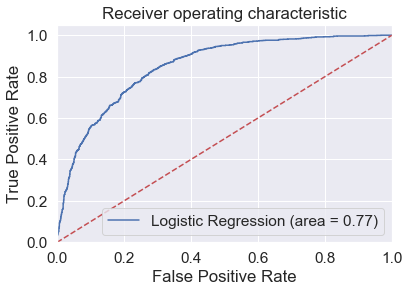

In [156]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y, logreg.predict_proba(data_final)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### with 0.5 probability the accuracy is 75% and recall is  79%

In [160]:
y_log_pred_train = logreg.predict(X_train)
ii = logreg.predict_proba(X_test)
probs_log = ii[:,1]  #taking a column
probs_log[probs_log > 0.6] =1  #setting thresholds
probs_log[probs_log <= 0.60] = 0
y_log_pred_test = logreg.predict(X_test)
print("Test accuracy", metrics.accuracy_score(y_test, probs_log))
print(classification_report(y_test, probs_log))


Test accuracy 0.7583081570996979
              precision    recall  f1-score   support

           0       0.74      0.82      0.77       336
           1       0.79      0.70      0.74       326

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.76       662
weighted avg       0.76      0.76      0.76       662



In [161]:
y_log_pred_train = logreg.predict(X_train)
print("Train Accuracy",metrics.accuracy_score(y_train, y_log_pred_train))
print(classification_report(y_train, y_log_pred_train))

Train Accuracy 0.7668680765357503
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       988
           1       0.75      0.81      0.78       998

    accuracy                           0.77      1986
   macro avg       0.77      0.77      0.77      1986
weighted avg       0.77      0.77      0.77      1986



#### Conclusion: The train and test accruacy show that the model has generalized well. Although this is a simple model it proved significant high accuracy. Lets move towards more complex algorithms like random forest

## Random Forest

In [152]:
#initializing reandom forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
RF_clf = RandomForestClassifier(n_estimators=2)
RF_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [153]:
#predicting on train and test data
#RF_clf.fit(X_train_dtm, y_train)
y_rf_pred_test = RF_clf.predict(X_test)
y_rf_pred_train = RF_clf.predict(X_train)

print(classification_report(y_test, y_rf_pred_test))
print(classification_report(y_train, y_rf_pred_train))

              precision    recall  f1-score   support

           0       0.64      0.80      0.71       336
           1       0.72      0.53      0.61       326

    accuracy                           0.67       662
   macro avg       0.68      0.67      0.66       662
weighted avg       0.68      0.67      0.66       662

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       988
           1       0.96      0.80      0.87       998

    accuracy                           0.88      1986
   macro avg       0.89      0.88      0.88      1986
weighted avg       0.89      0.88      0.88      1986



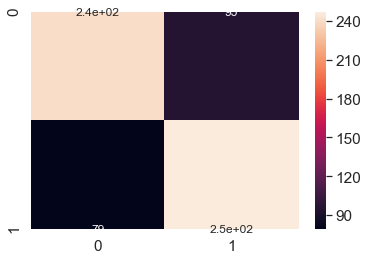

In [104]:
cm = metrics.confusion_matrix(y_test, y_rf_pred_test)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 12})# font size

In [105]:
probs_rf = RF_clf.predict_proba(test_final)
probs = probs_rf[:,1]  #taking a column
probs[probs > 0.25] =1  #setting thresholds
probs[probs <= 0.25] = 0
submission = test_account_demo[["CustomerID"]]
submission['Churn'] = probs
submission['Churn'] = submission['Churn'].map({1:"Yes",0:"No"})
#train_final['Churn'] = train_final['Churn'].map({'Yes': 1, 'No':0})
submission.to_csv("predictions.csv",index=False)

In [106]:
y_rf_pred_train = RF_clf.predict(X_train)
jj = RF_clf.predict_proba(X_test)
probs_rf = jj[:,1]  #taking a column
probs_rf[probs_rf > 0.60] =1  #setting thresholds
probs_rf[probs_rf <= 0.60] = 0
y_rf_pred_test = RF_clf.predict(X_test)
print(metrics.accuracy_score(y_test, probs_rf))
print(classification_report(y_test, probs_rf))

0.7356495468277946
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       336
           1       0.78      0.64      0.71       326

    accuracy                           0.74       662
   macro avg       0.74      0.73      0.73       662
weighted avg       0.74      0.74      0.73       662

